In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud


## Introduction

In this project we will analyze a dataset containing 2253 job offers for Data Analyst position scraped from *glassdoor.com in 2020*.

Let's import the data first and see how it looks like.

In [2]:
df = pd.read_csv('DataAnalyst.csv', index_col=0)
df.head()

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors,Easy Apply
0,"Data Analyst, Center on Immigration and Justic...",$37K-$66K (Glassdoor est.),Are you eager to roll up your sleeves and harn...,3.2,Vera Institute of Justice\n3.2,"New York, NY","New York, NY",201 to 500 employees,1961,Nonprofit Organization,Social Assistance,Non-Profit,$100 to $500 million (USD),-1,True
1,Quality Data Analyst,$37K-$66K (Glassdoor est.),Overview\n\nProvides analytical and technical ...,3.8,Visiting Nurse Service of New York\n3.8,"New York, NY","New York, NY",10000+ employees,1893,Nonprofit Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),-1,-1
2,"Senior Data Analyst, Insights & Analytics Team...",$37K-$66K (Glassdoor est.),We’re looking for a Senior Data Analyst who ha...,3.4,Squarespace\n3.4,"New York, NY","New York, NY",1001 to 5000 employees,2003,Company - Private,Internet,Information Technology,Unknown / Non-Applicable,GoDaddy,-1
3,Data Analyst,$37K-$66K (Glassdoor est.),Requisition NumberRR-0001939\nRemote:Yes\nWe c...,4.1,Celerity\n4.1,"New York, NY","McLean, VA",201 to 500 employees,2002,Subsidiary or Business Segment,IT Services,Information Technology,$50 to $100 million (USD),-1,-1
4,Reporting Data Analyst,$37K-$66K (Glassdoor est.),ABOUT FANDUEL GROUP\n\nFanDuel Group is a worl...,3.9,FanDuel\n3.9,"New York, NY","New York, NY",501 to 1000 employees,2009,Company - Private,Sports & Recreation,"Arts, Entertainment & Recreation",$100 to $500 million (USD),DraftKings,True


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2253 entries, 0 to 2252
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Job Title          2253 non-null   object 
 1   Salary Estimate    2253 non-null   object 
 2   Job Description    2253 non-null   object 
 3   Rating             2253 non-null   float64
 4   Company Name       2252 non-null   object 
 5   Location           2253 non-null   object 
 6   Headquarters       2253 non-null   object 
 7   Size               2253 non-null   object 
 8   Founded            2253 non-null   int64  
 9   Type of ownership  2253 non-null   object 
 10  Industry           2253 non-null   object 
 11  Sector             2253 non-null   object 
 12  Revenue            2253 non-null   object 
 13  Competitors        2253 non-null   object 
 14  Easy Apply         2253 non-null   object 
dtypes: float64(1), int64(1), object(13)
memory usage: 281.6+ KB


We can see from the first 5 rows that although summary above suggests every column is non-null there are values of *-1* included in *Competitors* or *Easy Apply* columns indicating that data is missing there

In [4]:
df.replace(-1, np.nan, inplace=True)
df.isna().sum()

Job Title              0
Salary Estimate        0
Job Description        0
Rating               272
Company Name           1
Location               0
Headquarters           0
Size                   0
Founded              660
Type of ownership      0
Industry               0
Sector                 0
Revenue                0
Competitors            0
Easy Apply             0
dtype: int64

Seems like some NaN values appeared, but it still doesn't apply to the last two columns. We need to pass *-1* as a string in order to take into account variables of type *object*.

In [5]:
df.replace("-1", np.nan, inplace=True)
df.isna().sum()

Job Title               0
Salary Estimate         1
Job Description         0
Rating                272
Company Name            1
Location                0
Headquarters          172
Size                  163
Founded               660
Type of ownership     163
Industry              353
Sector                353
Revenue               163
Competitors          1732
Easy Apply           2173
dtype: int64

Now we have more appropriate image of the missing data. Let's drop the columns with the majority of NaNs.

In [6]:
df = df.loc[:, df.isna().sum() < (0.5*len(df))]
df.columns

Index(['Job Title', 'Salary Estimate', 'Job Description', 'Rating',
       'Company Name', 'Location', 'Headquarters', 'Size', 'Founded',
       'Type of ownership', 'Industry', 'Sector', 'Revenue'],
      dtype='object')

In [7]:
# for numerical variables
df.describe()

,Rating,Founded
count,1981.000000,1593.000000
mean,3.731903,1978.362837
std,0.670332,47.822289
min,1.000000,1682.000000
25%,3.300000,1970.000000
50%,3.700000,1997.000000
75%,4.100000,2006.000000
max,5.000000,2019.000000


These statistics don't make much sense since they refer to companies and one company appears as many times in our dataframe as many offers it has posted.

In [8]:
# for categorical variables
cat_cols = df.select_dtypes(include='object')
cat_cols.describe()

,Job Title,Salary Estimate,Job Description,Company Name,Location,Headquarters,Size,Type of ownership,Industry,Sector,Revenue
count,2253,2252,2253,2252,2253,2081,2090,2090,1900,1900,2090
unique,1272,89,2253,1513,253,482,8,14,88,24,13
top,Data Analyst,$42K-$76K (Glassdoor est.),Are you eager to roll up your sleeves and harn...,"Staffigo Technical Services, LLC\n5.0","New York, NY","New York, NY",51 to 200 employees,Company - Private,IT Services,Information Technology,Unknown / Non-Applicable
freq,405,57,1,58,310,206,421,1273,325,570,615


Some interesting insights:
- Our earlier suspicion is confirmed - the most frequent company appeared 58 times
- New York is the most frequent location, we'll see further how big is the gap between it and the rest of the cities
- Unsurprisingly IT leads both in Industry and Sector categories
- We didn't take into account the "Unknown" value in Revenue column when replacing for NaNs.

In [9]:
# unknowns in categorical columns
for col in cat_cols:
    print(col + " = " + str((df[col].str.contains("Unknown")).sum()))

Job Title = 0
Salary Estimate = 0
Job Description = 0
Company Name = 0
Location = 0
Headquarters = 0
Size = 42
Type of ownership = 16
Industry = 0
Sector = 0
Revenue = 615


We can see that it wasn't only Revenue column. Let's transform these values and see if some other columns need to be dropped too.

In [10]:
unknowns = ["Revenue", "Size", "Type of ownership"]
for col in unknowns:
    df.loc[df[col].str.contains("Unknown", na=False), col] = np.nan

for col in cat_cols:
    print(col + " = " + str((df[col].str.contains("Unknown")).sum()))

Job Title = 0
Salary Estimate = 0
Job Description = 0
Company Name = 0
Location = 0
Headquarters = 0
Size = 0
Type of ownership = 0
Industry = 0
Sector = 0
Revenue = 0


In [11]:
df.isna().sum()

Job Title              0
Salary Estimate        1
Job Description        0
Rating               272
Company Name           1
Location               0
Headquarters         172
Size                 205
Founded              660
Type of ownership    179
Industry             353
Sector               353
Revenue              778
dtype: int64

In [12]:
sum(df["Revenue"].isna()) / len(df)

0.3453173546382601

The most NaNs appear in *Revenue* column now, but we don't need to remove it since there is still more than half of valid data to analyze.

## Ratings

In this section I'd like to see what's the average rating of companies in each sector.

In order to do this first we need to remove the duplicates so that each company contributes equally to the average.

In [13]:
df_unique = df.drop_duplicates(subset='Company Name', keep="first")
print(f'''
We\'ve dropped {len(df) - len(df_unique)} from {len(df)} total records.
This leaves us with {len(df_unique)} records. It's still a lot of data.''')


We've dropped 739 from 2253 total records.
This leaves us with 1514 records. It's still a lot of data.


Now let's see how many job offers each company posted on average for each sector.

In [14]:
off_per_comp = (df['Sector'].value_counts() / df_unique['Sector'].value_counts()).sort_values(ascending=False).round(1)
off_per_comp

Accounting & Legal                    2.2
Restaurants, Bars & Food Services     2.0
Business Services                     1.8
Information Technology                1.7
Insurance                             1.6
Telecommunications                    1.6
Education                             1.5
Finance                               1.5
Government                            1.4
Health Care                           1.4
Real Estate                           1.3
Media                                 1.3
Retail                                1.3
Aerospace & Defense                   1.3
Consumer Services                     1.3
Transportation & Logistics            1.2
Biotech & Pharmaceuticals             1.2
Construction, Repair & Maintenance    1.1
Oil, Gas, Energy & Utilities          1.1
Non-Profit                            1.1
Manufacturing                         1.1
Arts, Entertainment & Recreation      1.0
Mining & Metals                       1.0
Travel & Tourism                  

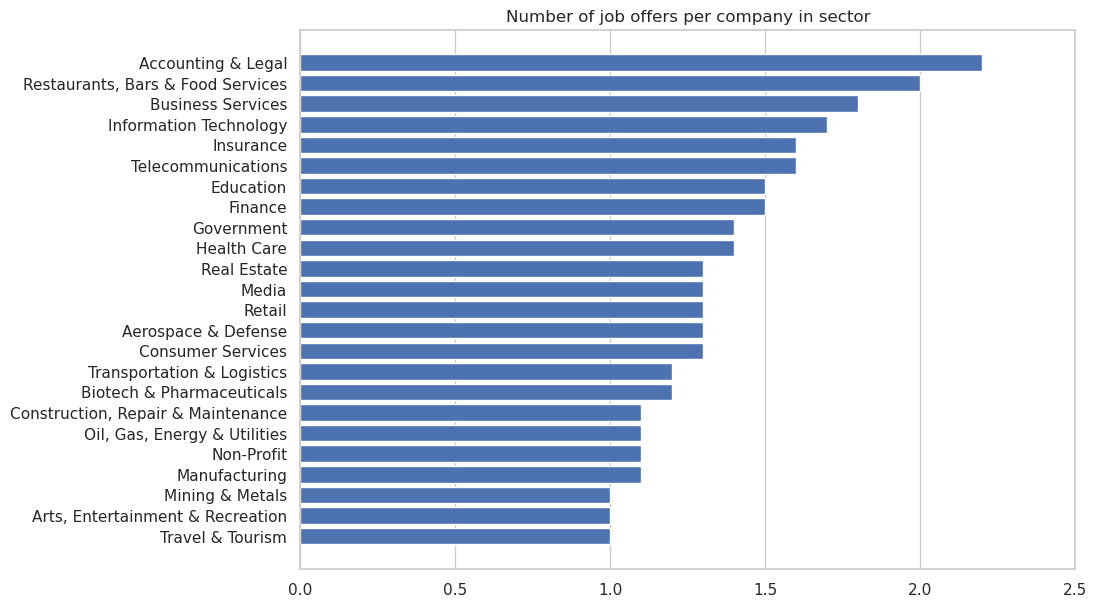

In [15]:
off_per_comp.sort_values(inplace=True)
plt.figure(figsize=(10,7))
sns.set(style="whitegrid")
plt.barh(off_per_comp.index, off_per_comp)
plt.grid(axis='y')
plt.title("Number of job offers per company in sector")
plt.xlim(0, 2.5)
plt.show()

We can see that for *Accounting & Legal* and *Restaurants, Bars & Food Services* each company posted on average more than two offers. It would be interesting to see if that's really the case or if it's one company that highly impacts the mean.

In [16]:
rest = df[df['Sector'] == "Restaurants, Bars & Food Services"]
rest['Company Name'].value_counts().sort_values(ascending=False)[:5]

Andiamo\n3.5            3
Ho Chunk\n2.8           2
Vespa Group LLC\n2.8    2
Flagstone Foods\n3.4    1
Name: Company Name, dtype: int64

In [17]:
acc = df[df['Sector'] == "Accounting & Legal"]
acc['Company Name'].value_counts().sort_values(ascending=False)[:5]

Lorven Technologies Inc\n4.0    19
EY\n3.8                          3
NTT DATA, Inc.\n2.9              3
Connor Group\n4.0                2
Horne LLP\n3.1                   1
Name: Company Name, dtype: int64

Okay, now we understand why it was necessary to get rid of duplicates before moving to average rating comparison in each sector. On the Accounting sector example we would get overly optimistic results for average rating while we can see that the rest companies doesn't necessarily match the most frequent one.

In [18]:
df_grouped = df_unique[['Sector', 'Rating']].groupby("Sector").agg(rating_avg=('Rating', 'mean'),
                                                                   rating_std=('Rating', 'std'),
                                                                   count=("Rating", 'size'))
df_grouped[:5]

,rating_avg,rating_std,count
Sector,,,
Accounting & Legal,3.575000,0.510804,20
Aerospace & Defense,3.647059,0.425907,17
"Arts, Entertainment & Recreation",3.800000,0.877496,7
Biotech & Pharmaceuticals,3.396296,0.622947,27
Business Services,3.813333,0.645759,292


In [19]:
df_grouped[df_grouped['count'] < 10]

,rating_avg,rating_std,count
Sector,,,
"Arts, Entertainment & Recreation",3.800000,0.877496,7
Mining & Metals,3.500000,NaN,1
Real Estate,3.837500,0.477905,9
"Restaurants, Bars & Food Services",3.125000,0.377492,4
Telecommunications,3.771429,0.508967,7
Travel & Tourism,4.000000,NaN,1


For the sake of having reliable results let's assume that 10 companies is the minimal number to represent the whole sector, so we will exclude the sectors above from the further analysis.

In [20]:
df_grouped = df_grouped[df_grouped['count'] > 10]

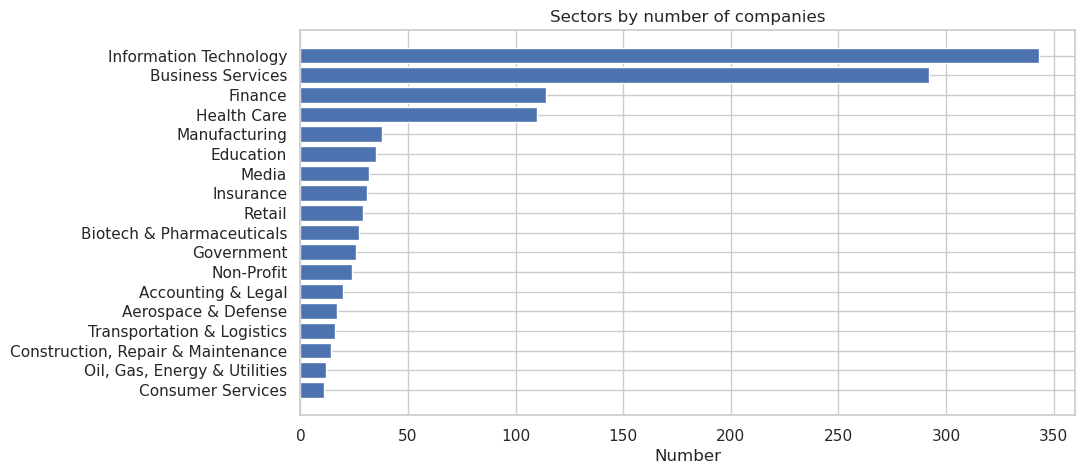

In [21]:
df_grouped = df_grouped.sort_values(by='count', ascending=True)

plt.figure(figsize=(10,5))
plt.barh(df_grouped.index, df_grouped['count'])
plt.title("Sectors by number of companies")
plt.xlabel("Number")
plt.show()

Number of IT and Business companies really outnumbers the rest of the sectors. Is quality going to match the quantity?

We will find out later. Now let's take a quick look on subcategory of Sectors which are Industries.

In [22]:
df_unique["Industry"].value_counts().nlargest(5)

IT Services                         166
Staffing & Outsourcing              148
Health Care Services & Hospitals    110
Consulting                           77
Computer Hardware & Software         74
Name: Industry, dtype: int64

In [23]:
df_unique_ind = df_unique["Industry"].value_counts().nlargest(15)
df_unique_ind = df_unique_ind.reset_index()
df_unique_ind.columns = ["Industry", "Count"]
df_unique_ind[:5]

,Industry,Count
0,IT Services,166
1,Staffing & Outsourcing,148
2,Health Care Services & Hospitals,110
3,Consulting,77
4,Computer Hardware & Software,74


In [24]:
# we want to somehow join to the df above the name of the sector industry is belonging to
df_unique_ind = df_unique_ind.merge(df[["Industry", "Sector"]].drop_duplicates("Industry"), on="Industry", how="left")
df_unique_ind[:5]

,Industry,Count,Sector
0,IT Services,166,Information Technology
1,Staffing & Outsourcing,148,Business Services
2,Health Care Services & Hospitals,110,Health Care
3,Consulting,77,Business Services
4,Computer Hardware & Software,74,Information Technology


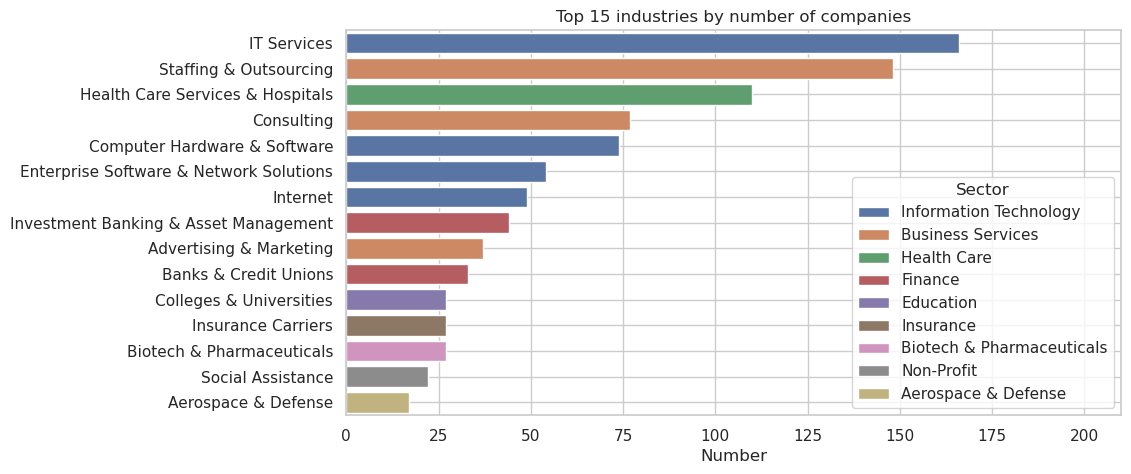

In [25]:
plt.figure(figsize=(10,5))
ax = sns.barplot(data=df_unique_ind, x='Count', y='Industry',
                 hue='Sector', palette=sns.color_palette(), dodge=False)
sns.move_legend(ax, "lower right") #bbox_to_anchor=(1, 1))
plt.xlim(0, 210)
ax.set(ylabel=None)
ax.set(xlabel="Number")
plt.grid(axis='y')
plt.title("Top 15 industries by number of companies")
plt.show()

Let's go back to the sectors and see how each of them ranks based on average rating of companies.

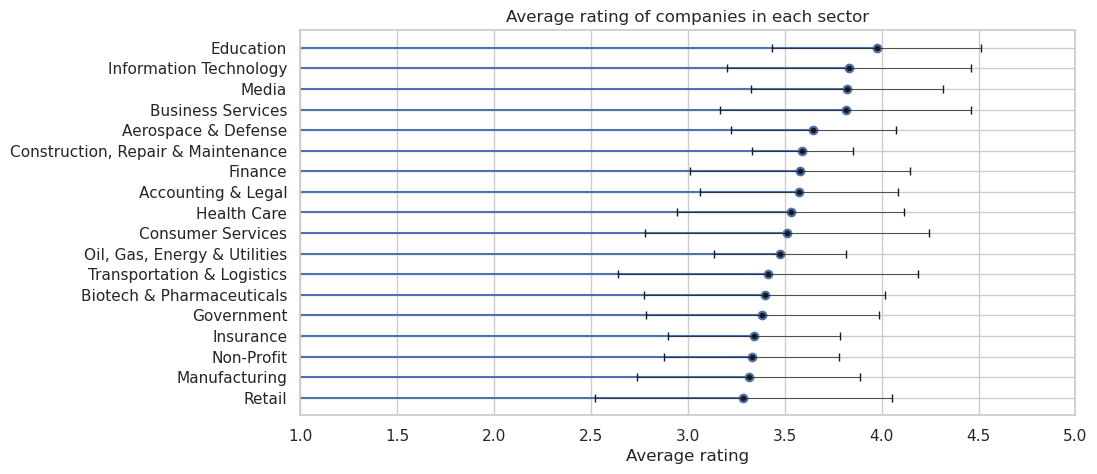

In [26]:
df_grouped = df_grouped[df_grouped['count'] > 10]
df_grouped = df_grouped.sort_values(by='rating_avg')

plt.figure(figsize=(10,5))
plt.hlines(df_grouped.index, xmin=0, xmax=df_grouped['rating_avg'])
plt.plot(df_grouped['rating_avg'], df_grouped.index, "o")
plt.errorbar(df_grouped['rating_avg'], df_grouped.index, xerr=df_grouped['rating_std'], fmt='.k', elinewidth=0.5, capsize = 3)
#plt.xticks(rotation=60)
plt.xlim(1,5)
plt.title("Average rating of companies in each sector")
plt.xlabel("Average rating")
plt.show()

Interesting that at the first glance *Retail* may appear the worst sector, but thanks to plotting the standard deviation we can also see that the data is pretty sparse there.

There is a different way of looking at the same statistics with even more information.

In [27]:
df_grouped = df_grouped.sort_values(by='rating_avg', ascending=False)
my_order = df_grouped["rating_avg"].index.tolist()

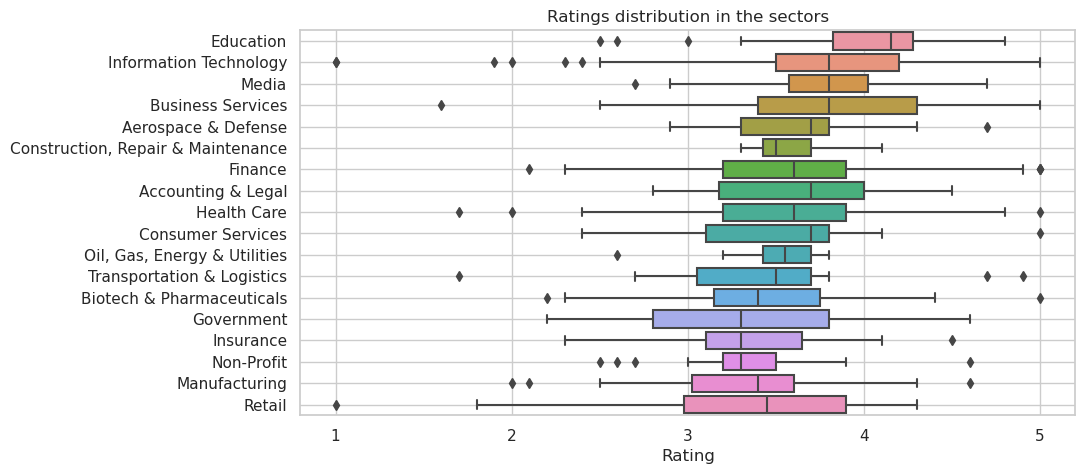

In [28]:
df_unique = df_unique[df_unique['Sector'].isin(df_grouped[df_grouped['count'] > 10].index)]

plt.figure(figsize=(10,5))
g = sns.boxplot(x="Rating", y="Sector",
            data=df_unique, order=my_order, orient="h") #order= my_order,
g.set_xticks(range(1,6))
g.set_ylabel(None)
g.set_title("Ratings distribution in the sectors")
plt.grid(axis='y')
plt.show()

* Having preserved the order from the previous plot, we can see how different conclusions we can draw just by changing the type of the plot. For example if we were to sort by median we would get a totally different ranking (besides our top 4 sectors).
* The plot above allows us to see more clearly how the data for rating spreads for each sector with the ends of vertical lines representing distance of 1.5 interquartile range from the median and black diamonds representing companies with ratings lying outside that range.
* This plot confirms our observation regarding *Retail* sector that it's not necessarily the worst sector having half of companies rated from 3 to 4.
* Thanks to including outliers on the plot we could see that there are some black sheeps in the well-reputed IT sector.

Now let's try to show both average rating and the number of companies!

In [29]:
my_cmap = plt.get_cmap("rocket_r")
# in order to map the ratings onto the color vector we need to scale them to 0-1 range
rescale = lambda y: (y - 1) / (5 - 1)
rescale(df_grouped['rating_avg']).sort_values(ascending=False)

Sector
Education                             0.743382
Information Technology                0.708033
Media                                 0.704688
Business Services                     0.703333
Aerospace & Defense                   0.661765
Construction, Repair & Maintenance    0.647500
Finance                               0.644027
Accounting & Legal                    0.643750
Health Care                           0.632569
Consumer Services                     0.627273
Oil, Gas, Energy & Utilities          0.618750
Transportation & Logistics            0.603333
Biotech & Pharmaceuticals             0.599074
Government                            0.596000
Insurance                             0.585484
Non-Profit                            0.582609
Manufacturing                         0.578289
Retail                                0.571429
Name: rating_avg, dtype: float64

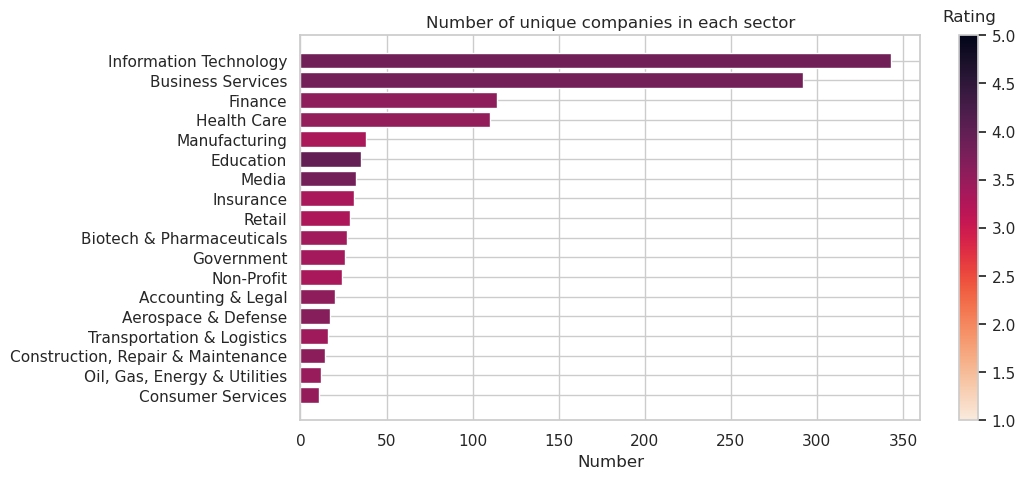

In [30]:
df_grouped = df_grouped.sort_values(by='count', ascending=True)

fig, ax = plt.subplots(figsize=(10,5))

ax.barh(df_grouped.index, df_grouped['count'],
         color=my_cmap(rescale(df_grouped['rating_avg'])))
plt.title("Number of unique companies in each sector")
plt.xlabel("Number")

norm = plt.Normalize(1, 5)
sm = plt.cm.ScalarMappable(cmap="rocket_r", norm=norm)
sm.set_array([])

cb = fig.colorbar(sm, ax=ax)
cb.ax.set_title('Rating', pad=10)
plt.show()

Well, that only reminds us that the differences are very subtle and every sector scores close on the average rating.

Finishing our rating analysis, I feel like we need to check if Size of the company isn't going to be a good predictor of the variable in question.

In [31]:
df_grouped_size = df_unique.groupby("Size").agg(rating_avg=('Rating', 'mean'),
                                                rating_std=('Rating', 'std'),
                                                count=("Rating", 'size'))
df_grouped_size

,rating_avg,rating_std,count
Size,,,
1 to 50 employees,3.903529,0.847125,190
10000+ employees,3.589674,0.437144,184
1001 to 5000 employees,3.487273,0.480317,220
201 to 500 employees,3.680000,0.620231,170
5001 to 10000 employees,3.597222,0.464204,72
501 to 1000 employees,3.530469,0.578426,128
51 to 200 employees,3.907944,0.684285,222


In [32]:
order = ['1 to 50 employees', '51 to 200 employees', '201 to 500 employees', '501 to 1000 employees',
         '1001 to 5000 employees', '5001 to 10000 employees', '10000+ employees']

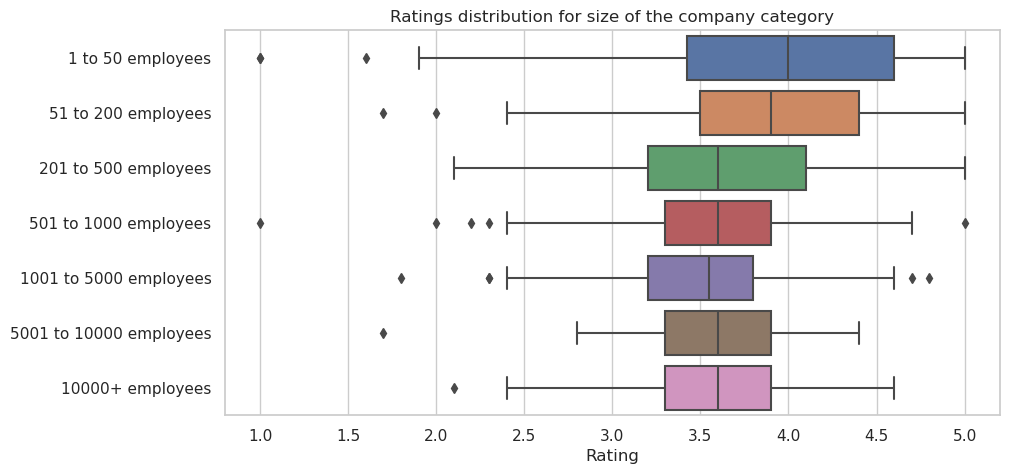

In [33]:
plt.figure(figsize=(10,5))
g = sns.boxplot(x="Rating", y="Size",
            data=df_unique, order=order, orient="h")
g.set_ylabel(None)
g.set_title("Ratings distribution for size of the company category")
plt.show()

The categories are sorted from the smallest to the biggest. There is a pattern here and it's not favourable one for the corporations. However, the smaller the size of the group, the bigger the variability in rating, so the distinction here isn't really that clear.

## Salaries

With regards to salary it's not necessary to remove the offers of the same company, so we will work on original data. <br>

We also need to keep in mind that these are estimations from the website, so what we are going to analyze is not precise reflection of reality.

In [34]:
print(df['Salary Estimate'].unique()[:6])

['$37K-$66K (Glassdoor est.)' '$46K-$87K (Glassdoor est.)'
 '$51K-$88K (Glassdoor est.)' '$51K-$87K (Glassdoor est.)'
 '$59K-$85K (Glassdoor est.)' '$43K-$76K (Glassdoor est.)']


We need to transform these estimates into more friendly format for analysis.

In [35]:
df[df['Salary Estimate'].isna()]

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue
2149,Configuration/Data Management Analyst III,NaN,Job Description\nPosition Title: Configuration...,4.4,Protingent\n4.4,"Kent, WA","Bellevue, WA",51 to 200 employees,2001.0,Company - Private,Staffing & Outsourcing,Business Services,$25 to $50 million (USD)


We also have one offer without *Salary Estimate*. Let's drop it.

In [36]:
df.dropna(subset=['Salary Estimate'], inplace=True)

In [37]:
# using regex library to get plain numbers from salary estimate - example below
string = '$37K-$66K (Glassdoor est.)'
values = re.findall(r'\d+', string)
values

['37', '66']

In [38]:
estimates = df['Salary Estimate'].tolist()

# for each record save the lower and upper value for salary estimate
salary_low = []
salary_high = []
for e in estimates:
    salary_range = re.findall(r'\d+', str(e))
    salary_range
    salary_low.append(int(salary_range[0]))
    salary_high.append(int(salary_range[1]))
df['Salary Low'] = np.array(salary_low)
df['Salary High'] = np.array(salary_high)

In [39]:
df[['Salary Estimate', 'Salary Low', 'Salary High']][:1]

,Salary Estimate,Salary Low,Salary High
0,$37K-$66K (Glassdoor est.),37,66


We can now drop the original feature.

In [40]:
df.drop('Salary Estimate', axis=1, inplace=True)

### Cities

Let's take a closer look now how the salaries differ in most frequent locations.

In [41]:
top_twenty = df['Location'].value_counts().nlargest(20).index.tolist()
print(top_twenty)

['New York, NY', 'Chicago, IL', 'San Francisco, CA', 'Austin, TX', 'Los Angeles, CA', 'Charlotte, NC', 'Houston, TX', 'Dallas, TX', 'San Diego, CA', 'Philadelphia, PA', 'Denver, CO', 'San Antonio, TX', 'San Jose, CA', 'Phoenix, AZ', 'Jersey City, NJ', 'Tempe, AZ', 'Seattle, WA', 'Irving, TX', 'Columbus, OH', 'Plano, TX']


In [42]:
df_cities = df[df['Location'].isin(top_twenty)] # df with records from the above cities
df_cities['Location'].value_counts()[:5]

New York, NY         310
Chicago, IL          130
San Francisco, CA    119
Austin, TX            81
Los Angeles, CA       80
Name: Location, dtype: int64

As promised in the beginning we now see what's the gap between NY and the rest of the cities.

In [43]:
df_sal = df_cities.groupby("Location").agg(count=("Location", 'size'), mean_low=('Salary Low', 'mean'), std_low=('Salary Low', 'std'),
                                           mean_high=('Salary High', 'mean'), std_high=('Salary High', 'std'))

df_sal[:5]

,count,mean_low,std_low,mean_high,std_high
Location,,,,,
"Austin, TX",81,43.308642,7.317175,74.098765,25.037275
"Charlotte, NC",78,51.179487,3.674212,85.166667,9.516106
"Chicago, IL",130,68.507692,16.833543,88.946154,20.866616
"Columbus, OH",29,31.724138,7.420515,59.034483,14.016528
"Dallas, TX",66,34.803030,8.896360,66.348485,17.258659


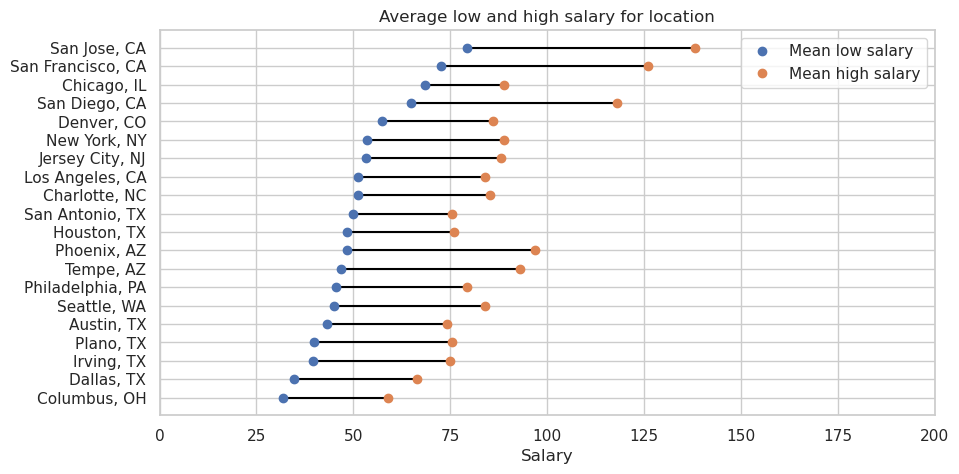

In [44]:
df_sal.sort_values(by="mean_low", inplace=True)

plt.figure(figsize=(10,5))
plt.hlines(df_sal.index, xmin=df_sal['mean_low'], xmax=df_sal['mean_high'], colors='black')
plot1, = plt.plot(df_sal['mean_low'], df_sal.index, "o", label="low")
plot2, = plt.plot(df_sal['mean_high'], df_sal.index, "o", label="high")
plt.legend([plot1,plot2],["Mean low salary", "Mean high salary"])
plt.xlim(0,200)
plt.title("Average low and high salary for location")
plt.xlabel("Salary")
plt.show()

It looks like location can explain the variability in salary range, but we have to keep in mind the limitations of taking the average.

Let's investigate this topic further.

In [45]:
df.columns

Index(['Job Title', 'Job Description', 'Rating', 'Company Name', 'Location',
       'Headquarters', 'Size', 'Founded', 'Type of ownership', 'Industry',
       'Sector', 'Revenue', 'Salary Low', 'Salary High'],
      dtype='object')

We will transform Salary variables again but this time **unpivoting** them in order to use some of the seaborn library funtionalities.

In [46]:
df.rename(columns={'Salary Low':'Low', 'Salary High':'High'}, inplace=True)
melted_sal = pd.melt(df, id_vars=list(df.columns[:-2]),value_vars=["Low", "High"], var_name="Salary type", value_name="Salary")
melted_sal[:5]

,Job Title,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Salary type,Salary
0,"Data Analyst, Center on Immigration and Justic...",Are you eager to roll up your sleeves and harn...,3.2,Vera Institute of Justice\n3.2,"New York, NY","New York, NY",201 to 500 employees,1961.0,Nonprofit Organization,Social Assistance,Non-Profit,$100 to $500 million (USD),Low,37
1,Quality Data Analyst,Overview\n\nProvides analytical and technical ...,3.8,Visiting Nurse Service of New York\n3.8,"New York, NY","New York, NY",10000+ employees,1893.0,Nonprofit Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),Low,37
2,"Senior Data Analyst, Insights & Analytics Team...",We’re looking for a Senior Data Analyst who ha...,3.4,Squarespace\n3.4,"New York, NY","New York, NY",1001 to 5000 employees,2003.0,Company - Private,Internet,Information Technology,NaN,Low,37
3,Data Analyst,Requisition NumberRR-0001939\nRemote:Yes\nWe c...,4.1,Celerity\n4.1,"New York, NY","McLean, VA",201 to 500 employees,2002.0,Subsidiary or Business Segment,IT Services,Information Technology,$50 to $100 million (USD),Low,37
4,Reporting Data Analyst,ABOUT FANDUEL GROUP\n\nFanDuel Group is a worl...,3.9,FanDuel\n3.9,"New York, NY","New York, NY",501 to 1000 employees,2009.0,Company - Private,Sports & Recreation,"Arts, Entertainment & Recreation",$100 to $500 million (USD),Low,37


In [47]:
melted_sal['Salary type'].value_counts()

Low     2252
High    2252
Name: Salary type, dtype: int64

Now we have doubled the number of rows but we can use *Salary type* as a variable. Before moving to cities comparison we can simply compare both ends of Salary Estimates.

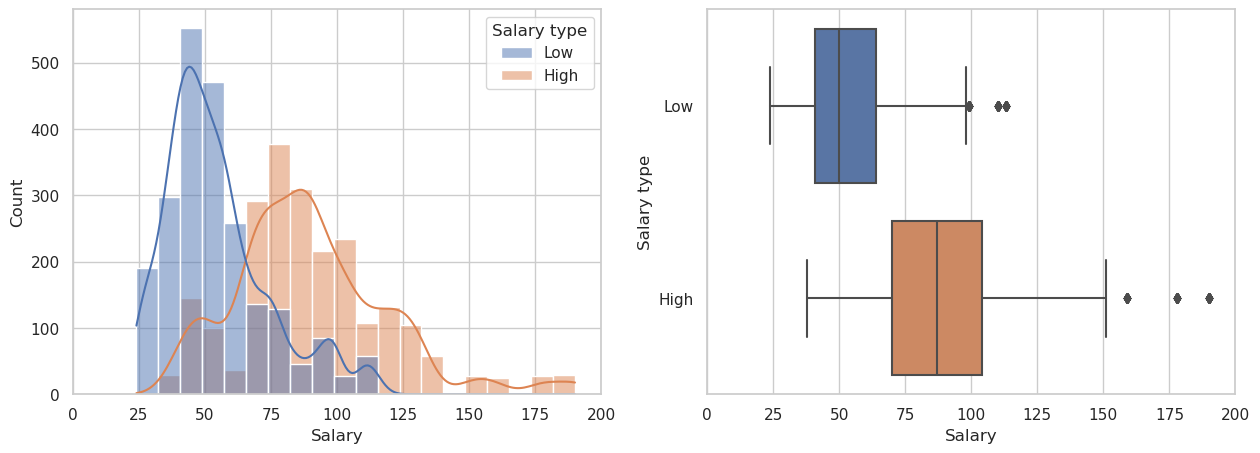

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
sns.histplot(ax=axes[0], data=melted_sal, x="Salary", hue="Salary type", bins=20, kde=True)
axes[0].set_xlim(0, 200)
sns.boxplot(ax=axes[1], data=melted_sal, x="Salary", y="Salary type")
axes[1].set_xlim(0, 200)
plt.show()

It was obvious that they'll differ, but it was nice to see by how much. Low values seem to be more densely distributed with a few outliers.

Now let's filter for top 20 most frequent cities.

In [49]:
melted_df_cities = melted_sal[melted_sal['Location'].isin(top_twenty)] # df with records from the above cities
melted_df_cities['Location'].value_counts()[:5]

New York, NY         620
Chicago, IL          260
San Francisco, CA    238
Austin, TX           162
Los Angeles, CA      160
Name: Location, dtype: int64

[]

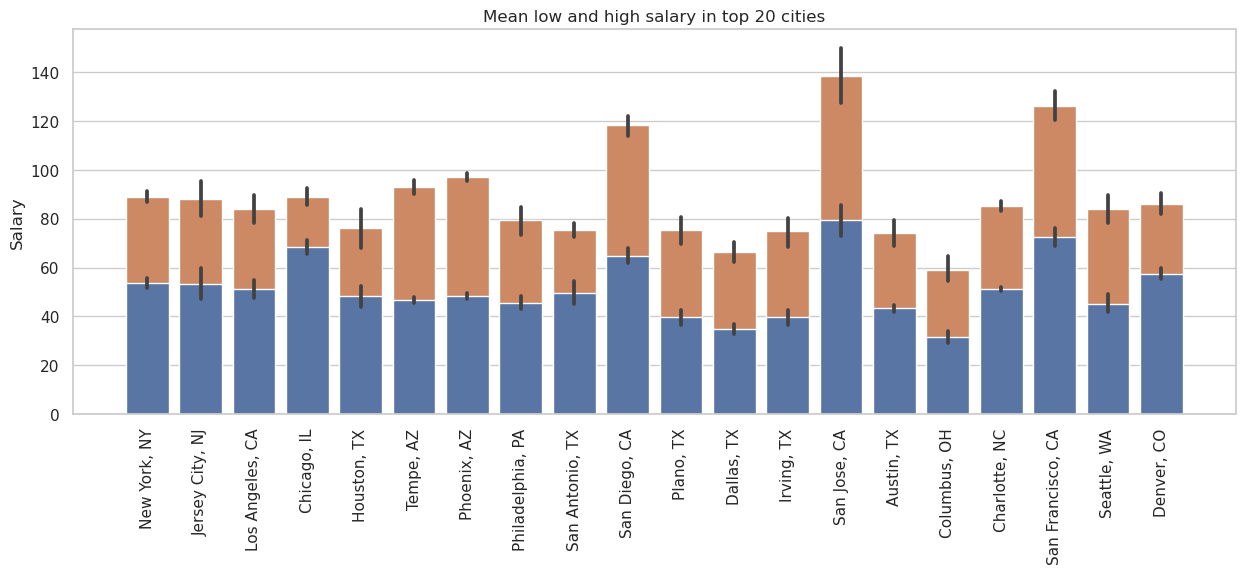

In [50]:
# here we will use the dataset with salary range in two separate columns, since it's easier to plot
plt.figure(figsize=(15,5))
sns.barplot(data=df_cities, x="Location", y="Salary High", color='#dd8452')
sns.barplot(data=df_cities, x="Location", y="Salary Low", color='#4c72b0')
plt.title("Mean low and high salary in top 20 cities")
plt.ylabel("Salary")
plt.xlabel(None)
plt.xticks(rotation=90)
plt.plot()

Californian cities really stand out from the rest in terms of low and high ends of salary estimations. <br>
Chicago's low boundary is also worth noting.

[]

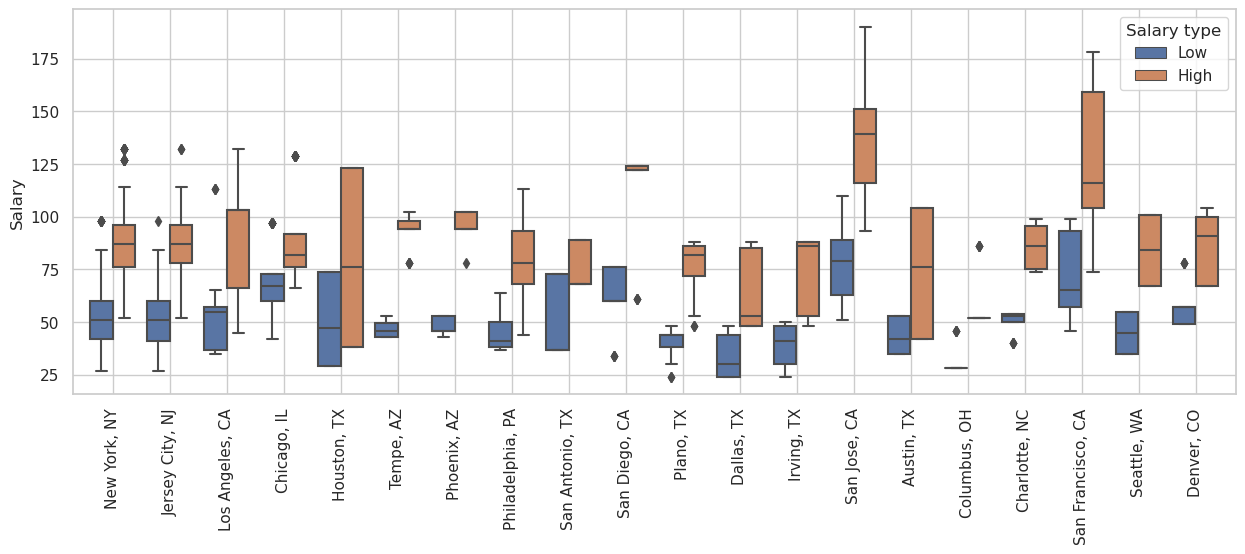

In [51]:
plt.figure(figsize=(15,5))
sns.boxplot(data=melted_df_cities, x="Location", y="Salary", hue="Salary type")
plt.xticks(rotation=90)
plt.grid(axis="x")
plt.xlabel(None)
plt.plot()

A lot of going on here, but the plot provides some important information. There is a better way to visualize it though.

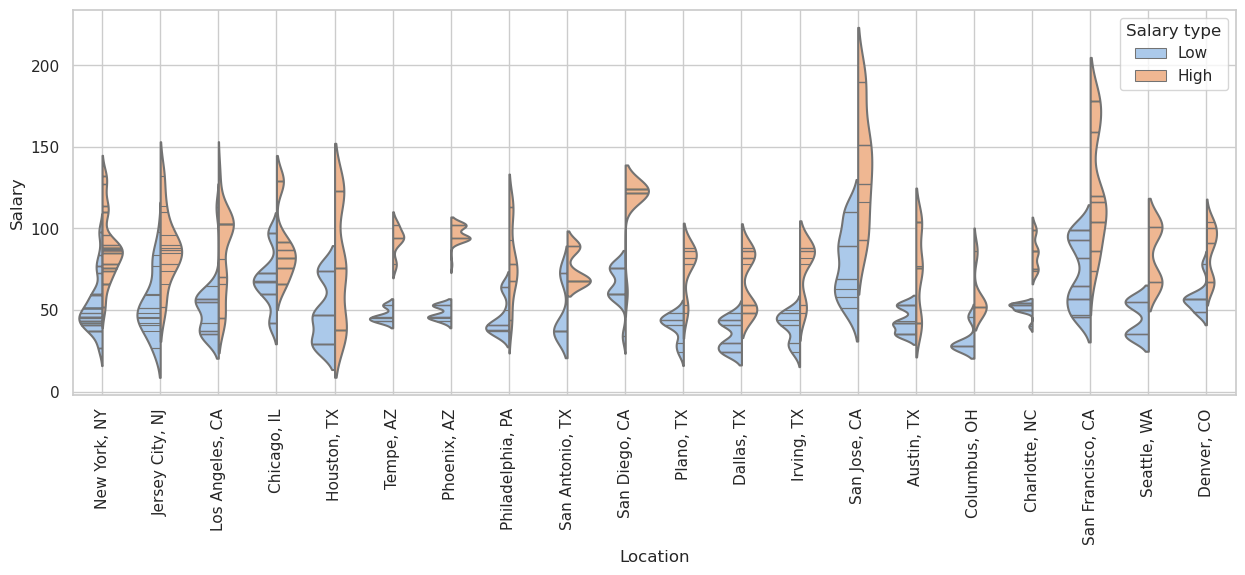

In [52]:
plt.figure(figsize=(15,5))
sns.violinplot(data=melted_df_cities, x="Location", y="Salary", hue="Salary type", split=True, inner="stick",
               palette="pastel")
plt.xticks(rotation=90)
plt.grid(axis="x")
plt.show()

So interesting to see how distributions seem to follow some specific pattern for each region - California, Arizona, Texas and NY/NJ. There are some exceptions but generally we can deduce that region was a strong predictor in estimating the salary for a job offer.

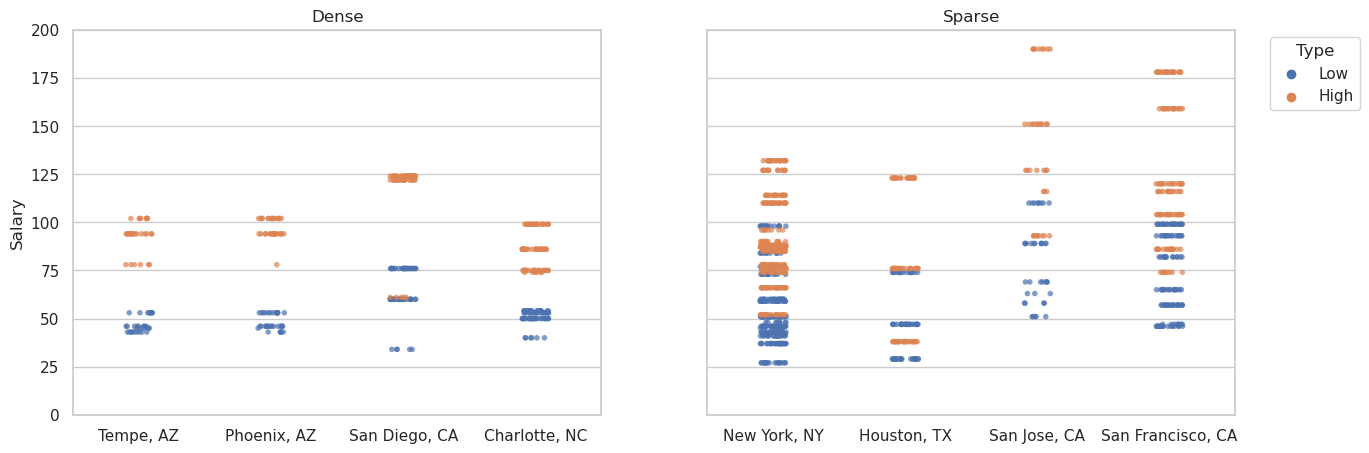

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(15,5), sharey=True)
sns.stripplot(ax=axes[0], data=melted_df_cities[melted_df_cities['Location'].isin(["San Diego, CA", "Charlotte, NC", "Phoenix, AZ", "Tempe, AZ"])], x="Location", y="Salary",
              hue="Salary type", size=4, alpha=0.7, legend=False)
axes[0].set_xlabel(None)
axes[0].set_title("Dense")
sns.stripplot(ax=axes[1], data=melted_df_cities[melted_df_cities['Location'].isin(["San Jose, CA", "San Francisco, CA", "Houston, TX", "New York, NY"])], x="Location", y="Salary",
              hue="Salary type", size=4, alpha=0.7)
axes[1].set_xlabel(None)
axes[1].set_title("Sparse")
plt.legend(title="Type", bbox_to_anchor=(1.25, 1), loc="upper right")
plt.ylim(0, 200)
plt.show()

Plots above help us understand why the distributions for chosen cities look the way they do. As you can see it isn't because of the lack of data, but more because of very low or high variability.

### Experience

Okay, let's compare Junior vs Senior position in terms of salary now.

In [54]:
juniors = df['Job Title'].str.contains("Junior|Jr")
print(df[juniors]['Job Title'].unique()[:5])
len(df[juniors])

['Entry Level / Jr. Data Analyst' 'Junior Data Analyst'
 'Junior Data Analytics Solutions Analyst'
 'Data Analyst-Junior Profiles also works-Only NY/NJ Candidates Please on w2 Only'
 'Data Analyst Junior']


72

In [55]:
seniors = df['Job Title'].str.contains("Senior|Sr")
print(df[seniors]['Job Title'].unique()[:5])
len(df[seniors])

['Senior Data Analyst, Insights & Analytics Team [Customer Operations]'
 'Senior Data Analyst' 'Senior Analyst, Data Science'
 'Senior Data Analyst, Disney+'
 'Sr. Business Intelligence Engineer / Data Analyst']


411

In [56]:
df["Experience"] = np.nan
df.loc[seniors, 'Experience'] = "Senior"
df.loc[juniors, 'Experience'] = "Junior"
df['Experience'].value_counts()

Senior    411
Junior     72
Name: Experience, dtype: int64

We've managed to extract only that many offers referring specifically to our interest. This isn't much considering the size of dataset, but it's sufficient to make some basic analysis.  

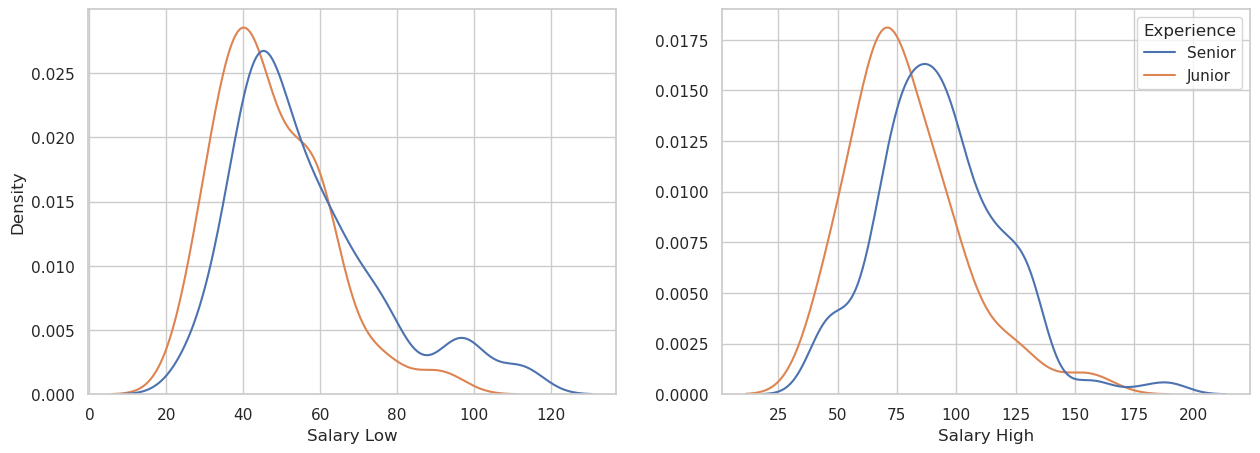

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
sns.kdeplot(ax=axes[0], data=df, x="Low", hue="Experience", common_norm=False, legend=False)
axes[0].set_xlabel("Salary Low")
sns.kdeplot(ax=axes[1], data=df, x="High", hue="Experience", common_norm=False)
axes[1].set_xlabel("Salary High")
axes[1].set_ylabel(None)
plt.show()

In [58]:
seniors_72 = df[seniors].sample(72)
# taking the sample of the size of junior offers number from senior positions
df_to_show = pd.concat([df[juniors], seniors_72])

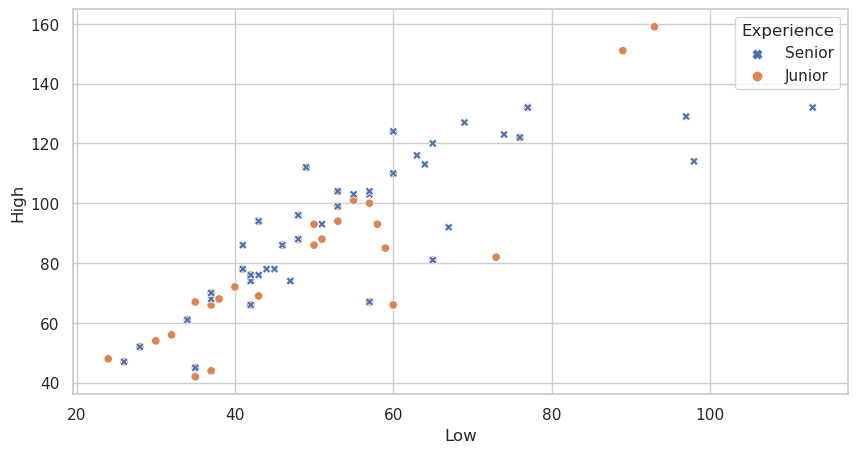

In [59]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=df_to_show, x="Low", y="High", hue="Experience", hue_order = ['Senior', 'Junior'], style="Experience")
plt.show()

This came as a surprise. But I also think that location is a stronger predictor and comparing positions makes sense only within one city or state.

## Tools

In the final part I would like to extract from offers' descriptions information regarding demanded tools knowledge.

In [60]:
desc = df['Job Description'].iloc[24]
# some description
print(desc)

Dash Technologies is an industry leading software solutions providers as well as an IT training provider for over a decade now.

Job Description

Eligibility Criteria
Bachelor's or master’s degree in Computer Science or related subject.
Candidates who are authorized to work in US.
0-1 years’ experience of Data Analyst
Required Skills
Candidate having Analytical skills with core experience
Role involves developing queries from MySQL.
Knowledge of SQL, Excel or similar applications is mandatory.
Expertise in MySQL & related querying languages.
Expertise in Excel and advance excel skills
Should have experience in Reporting and business analytics.
Must have experience in MSBI (SSIS, SSRS, SSAS).
SQL server and Data Warehousing
Very strong experience in TSQL
SQL Store procedures,
Data analysis
Extensive experience to perform Data Analysis Activities
Designs Data Architectures
Responsibilities
Write efficient T-SQL.
ETL using Bulk Insert, SSIS.
Performance Tuning and Optimization using nativ

We are going to split each description on single phrases and transform words to their root forms what is called a **lemmatization** process.

In [61]:
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('wordnet2022')
#nlp = load('en_core_web_sm')
! cp -rf /usr/share/nltk_data/corpora/wordnet2022 /usr/share/nltk_data/corpora/wordnet
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package omw-1.4 to /home/ec2-user/nltk_data...
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data] Downloading package wordnet2022 to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/wordnet2022.zip.


cp: cannot stat ‘/usr/share/nltk_data/corpora/wordnet2022’: No such file or directory


In [62]:
descs = df['Job Description'].tolist()


tools = {'tableau':0, 'sql':0, 'python':0, 'r':0, 'spark':0, 'hadoop':0,
         'docker':0, 'excel':0, 'java':0, 'powerbi':0, 'aws':0, 'gcp':0, 'azure':0}

tools_exc = {'tableau':0, 'sql':0, 'python':0, 'r':0, 'spark':0, 'hadoop':0,
             'docker':0, 'excel':0, 'java':0, 'powerbi':0, 'aws':0, 'gcp':0, 'azure':0}

#for wordcloud
every_word = ''

#first approach
for desc in descs:

    words = [x.lower() for x in desc.split()]

    for i, word in enumerate(words):
        if word in tools.keys():
            tools[word] += 1

# second approach
for desc in descs:
    appeared = {'tableau': False, 'sql':False, 'python':False, 'r':False, 'spark':False, 'hadoop':False,
                'docker':False, 'excel':False, 'java':False, 'powerbi':False, 'aws':False, 'gcp':False, 'azure':False}

    words = [x.lower() for x in desc.split()]

    for i, word in enumerate(words):

        if word in tools_exc.keys() and not appeared[word]:
            tools_exc[word] += 1

        # 1st exception to account for space-separated cases
        elif (word == "bi" and words[i-1] == "power") and not appeared['powerbi']:
            tools_exc['powerbi'] += 1
            appeared['powerbi'] = True

        # 2nd exception
        elif word == "pyspark" and not appeared['spark']:
            tools_exc['spark'] += 1
            appeared['spark'] = True

        # 3rd exception
        elif (word == "javascript" or word == "jquery") and not appeared['java']:
            tools_exc['java'] += 1
            appeared['java'] = True

        # 4th exception
        elif word == "cloud":
            if words[i-1] == "google" and not appeared['gcp']:
                tools_exc['gcp'] += 1
                appeared['gcp'] = True
            if words[i-1] == "microsoft" and not appeared['azure']:
                tools_exc['azure'] += 1
                appeared['azure'] = True
        elif (word == "web" and words[i-1] == "amazon") and not appeared['aws']:
            tools_exc['aws'] += 1
            appeared['aws'] = True

        # 5th exception
        elif (word == "mssql" or word == "mysql" or word == "postgresql" or word == "tsql") and not appeared['sql']:
            tools_exc['sql'] +=1
            appeared['sql'] = True

        # lemmatizing for inflected forms of the same word
        every_word += lemmatizer.lemmatize(word) + ' '

print(tools)
print(tools_exc)

{'tableau': 389, 'sql': 1547, 'python': 364, 'r': 177, 'spark': 28, 'hadoop': 77, 'docker': 2, 'excel': 639, 'java': 51, 'powerbi': 42, 'aws': 140, 'gcp': 6, 'azure': 68}
{'tableau': 389, 'sql': 1574, 'python': 364, 'r': 177, 'spark': 32, 'hadoop': 77, 'docker': 2, 'excel': 639, 'java': 66, 'powerbi': 130, 'aws': 123, 'gcp': 18, 'azure': 72}


Taking exceptions into account allowed us to catch more occurrences. This is especially important for Microsoft's Power BI tool.

In [63]:
tools = {k:v for k, v in sorted(tools_exc.items(), key=lambda item: item[1], reverse=True)}

In [64]:
print(tools)

{'sql': 1574, 'excel': 639, 'tableau': 389, 'python': 364, 'r': 177, 'powerbi': 130, 'aws': 123, 'hadoop': 77, 'azure': 72, 'java': 66, 'spark': 32, 'gcp': 18, 'docker': 2}


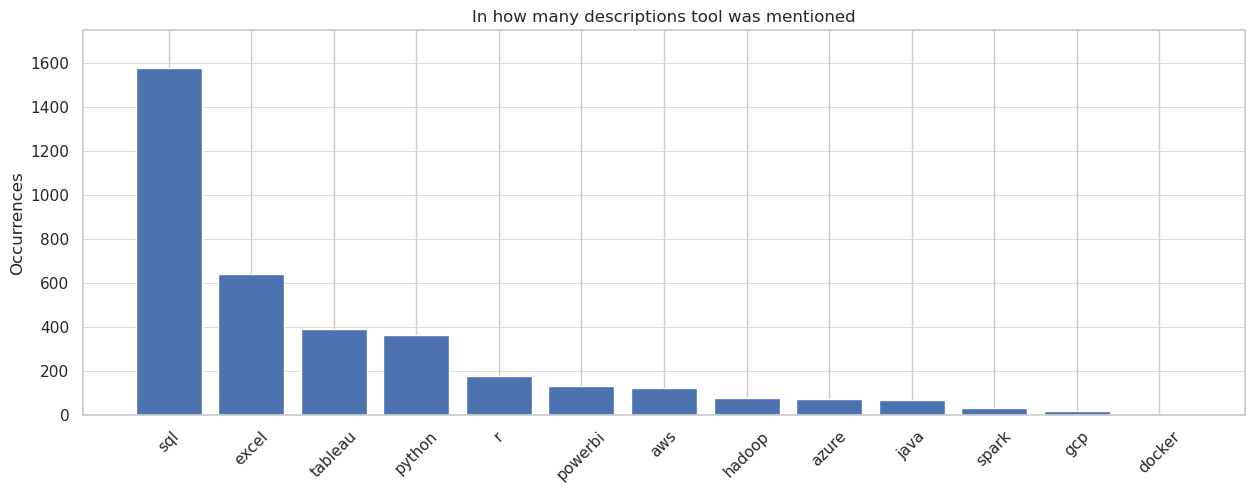

In [65]:
plt.figure(figsize=(15,5))
plt.bar(tools.keys(), tools.values())
plt.xticks(rotation=45)
plt.ylim(0, 1750)
plt.title("In how many descriptions tool was mentioned")
plt.ylabel("Occurrences")
plt.grid(axis='y', linewidth=0.5, linestyle='-')
plt.show()

If they could only see how much data analysis we were able to do with Python...

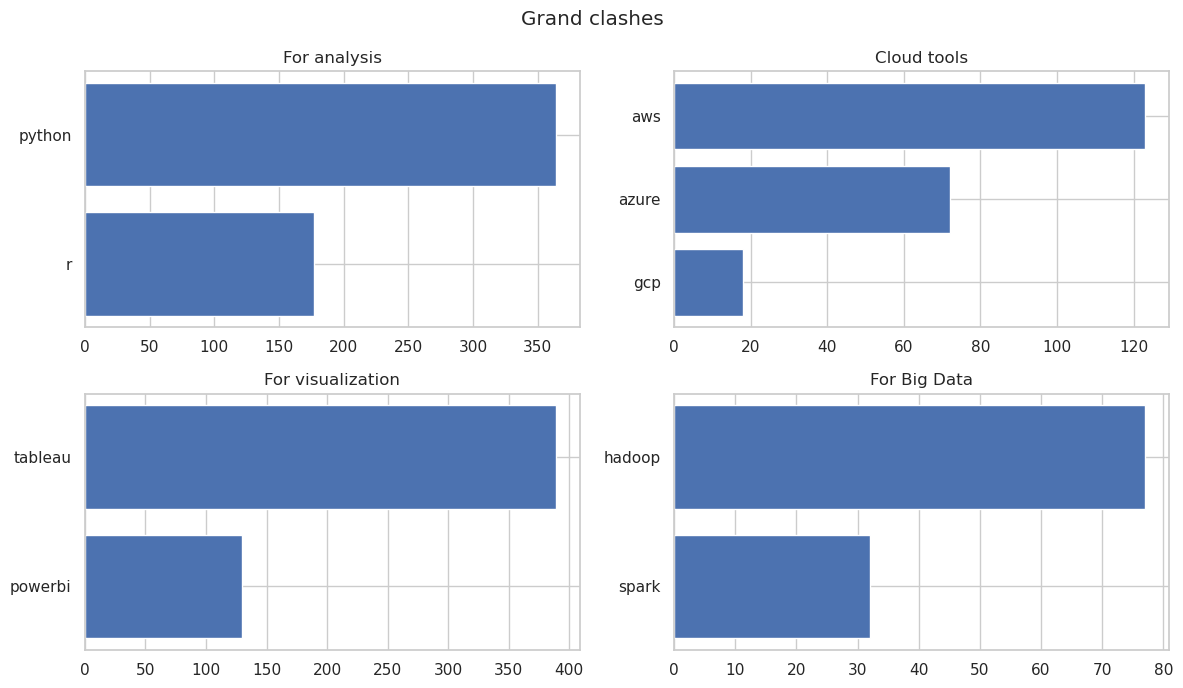

In [66]:
first = ["r", "python"]
first_val = [tools[x] for x in first]
second = ["gcp", "azure", "aws"]
second_val = [tools[x] for x in second]
third = ["powerbi", "tableau"]
third_val = [tools[x] for x in third]
fourth = ["spark", "hadoop"]
fourth_val = [tools[x] for x in fourth]

fig, ax = plt.subplots(2,2, figsize=(12,7))
ax[0, 0].set_title("For analysis")
ax[0, 0].barh(first, first_val)
ax[0, 1].set_title("Cloud tools")
ax[0, 1].barh(second, second_val)
ax[1, 0].set_title("For visualization")
ax[1, 0].barh(third, third_val)
ax[1, 1].set_title("For Big Data")
ax[1, 1].barh(fourth, fourth_val)
fig.suptitle('Grand clashes')
fig.tight_layout()
plt.show()

This data is from June 2020. It's not old, but we have to keep in mind how rapidly technology is changing. Nevertheless, we can see here who is the leader in its field, at least in the US job market.

In [67]:
wordcloud = WordCloud(width=800, height=400).generate(every_word)

Lastly, let me present you a cool way to look at the most frequently occurring words in job offers' descriptions.   

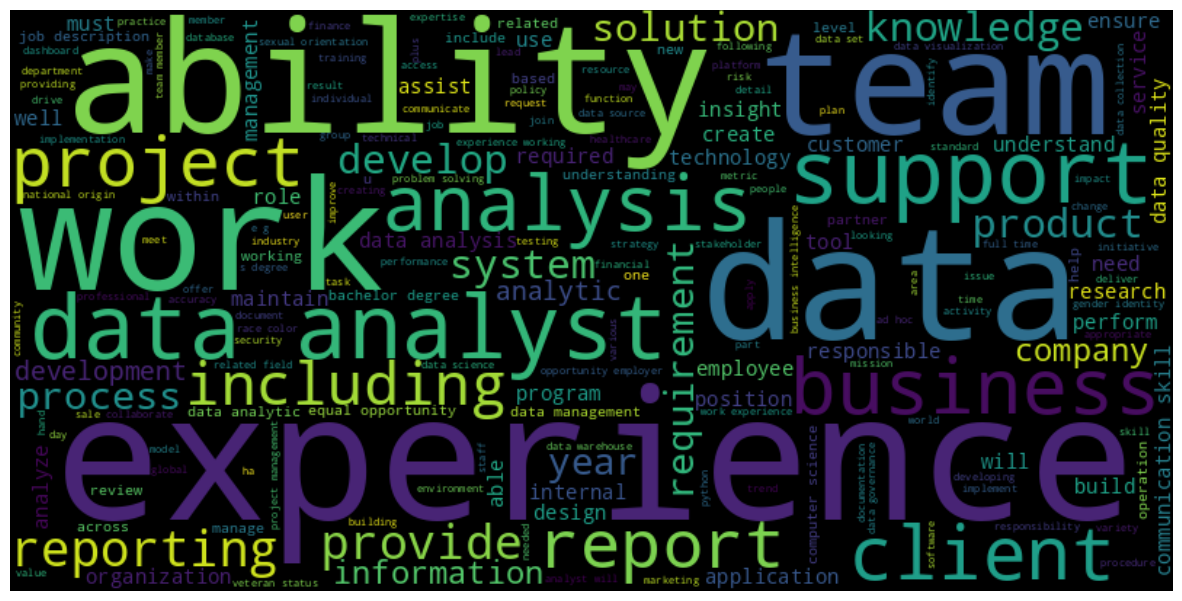

In [68]:
plt.figure(figsize = (15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Aren't these familiar?

## The end

Thank you for taking the time to see my work. If you noticed some serious mistakes or don't understand some part of the code, please let me know. Thank you!